<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/DHOD/blob/u%2FEiffL%2FNFW/nb/NFW_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%tensorflow_version 2.x
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/DHOD.git

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
from diffhod.distributions.NFW import RadialNFWProfile, NFWProfile

Populating the interactive namespace from numpy and matplotlib


In [2]:
## Code imported from https://github.com/CullanHowlett/NFWdist/blob/master/python/NFWdist.py
import numpy as np
from scipy import special

r"""  The Standard Distribution Functions for the 3D NFW Profile

      Density, distribution function, quantile function and random generation for the 3D NFW profile

      Usage:
      dnfw(x, con = 5, log = FALSE)
      pnfw(q, con = 5, logp = FALSE)
      qnfw(p, con = 5, logp = FALSE)
      rnfw(n, con = 5)

      dnfw gives the density, pnfw gives the distribution function, qnfw gives the quantile function, and rnfw generates random deviates.

      Arguments:
        x, q: array_like
          Vector of quantiles. This is scaled such that x=R/Rvir for NFW. This means the PDF is only defined between 0 and 1.

        p: array_like
          Vector of probabilities

        n: array_like
          Number of observations. If n has the attribute 'len()', i.e., is not a scalar, the length is taken to be the number required.

        con: scalar/array_like, optional
          The NFW profile concentration parameter, where c=Rvir/Rs.
          If con is scalar then the output of the routines is array_like with with shape(len(q)).
          If con is array_like then the output of the routines is array_like with shape(len(q),len(con))

        log, logp: logical, optional
          if True, probabilities/densities p are returned as log(p).

      Examples:
        see test.py

      Notes:
        The novel part of this package is the general solution for the CDF inversion (i.e. qnfw). 
        As far as we can see this has not been published anywhere, and it is a useful function for populating halos in something like an HOD.
        This seems to work at least as efficiently as accept/reject, but it is ultimately much more elegant code in any case.

      Authors:
        Cullan Howlett & Aaron Robotham
"""

def pnfwunorm(q, con=5):
  if hasattr(con, '__len__'):
    y = np.outer(q,con)
  else:
    y = q*con
  return np.log(1.0 + y)-y/(1.0 + y)

def dnfw(x, con=5, log=False):
  if hasattr(con, '__len__'):
    con = np.array(con)
    d = np.outer(x,con**2)/((np.outer(x,con)+1.0)**2*(1.0/(con+1.0)+np.log(con+1.0)-1.0))
  else:
    d = (x*con**2)/(((x*con)+1.0)**2*(1.0/(con+1.0)+np.log(con+1.0)-1.0))
  if hasattr(x, '__len__'):
    d[x>1] = 0 
    d[x<=0] = 0
  else:
    if (x > 1):
      d = 0
    elif (x <= 0):
      d = 0
  if (log):
    return np.log(d)
  else:
    return d

def pnfw(q, con=5, logp=False):
  p = pnfwunorm(q, con=con)/pnfwunorm(1, con=con)
  if hasattr(q, '__len__'):
    p[q>1] = 1
    p[q<=0] = 0
  else:
    if (q > 1):
      p = 1
    elif (q <= 0):
      p = 0
  if(logp):
    return np.log(p)
  else:
    return p

def qnfw(p, con=5, logp=False):
  if (logp):
    p = np.exp(p)
  if hasattr(p, '__len__'):
    p[p>1] = 1
    p[p<=0] = 0
  else:
    if (p > 1):
      p = 1
    elif (p <= 0):
      p = 0
  if hasattr(con, '__len__'):
    p = np.outer(p,pnfwunorm(1, con=con))
  else:
    p *= pnfwunorm(1, con=con)
  return (-(1.0/np.real(special.lambertw(-np.exp(-p-1))))-1)/con

def rnfw(n, con=5):
  if hasattr(n, '__len__'):
    n=len(n)
  return qnfw(np.random.rand(int(n)), con=con)

In [3]:
distribution = RadialNFWProfile(concentration=10, Rvir=1)

In [4]:
r = np.linspace(0.001,1)

log_p = distribution.log_prob(r)

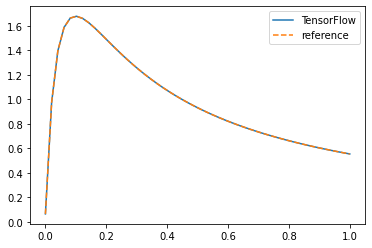

In [6]:
plot(r, exp(log_p), label='TensorFlow')
plot(r, dnfw(r,con=10), '--', label='reference')
legend()

In [7]:
%timeit distribution.sample(1e6)

60.9 ms ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
%timeit rnfw(1e6,con=10)

243 ms ± 2.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


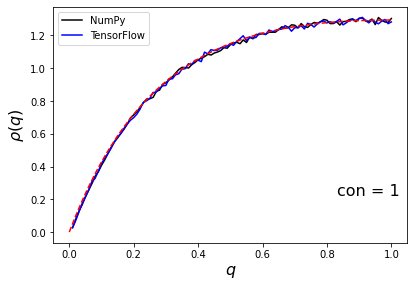

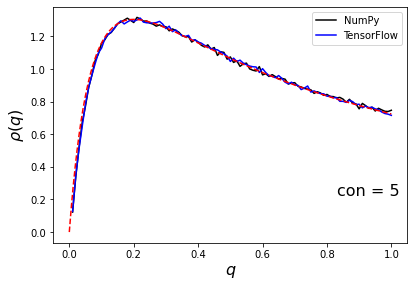

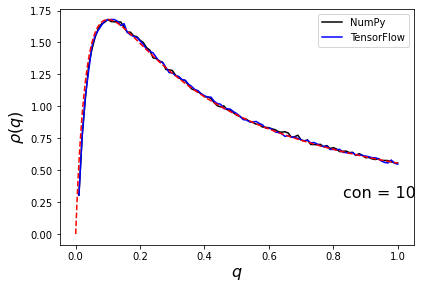

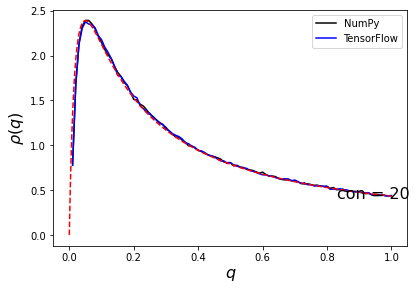

In [9]:
# Some plots of the analytic and randomly-drawn NFW PDF
nsamples = 1e6
for con in [1,5,10,20]:
  distr = RadialNFWProfile(concentration=con, Rvir=1)
  hist = np.histogram(rnfw(nsamples,con=con), bins=100, density=True)
  tfhist = np.histogram(distr.sample(nsamples), bins=100, density=True)

  fig = plt.figure(con)
  ax1=fig.add_axes([0.13,0.13,0.82,0.82])
  ax1.plot(hist[1][1:], hist[0], color='k', linewidth=1.5,  label='NumPy')
  ax1.plot(tfhist[1][1:], tfhist[0], color='b', linewidth=1.5,  label='TensorFlow')
  legend()
  ax1.plot(np.linspace(0,1,1000), dnfw(np.linspace(0,1,1000),con=con), color='r', ls='--')
  ax1.set_xlabel(r'$q$', fontsize=16)
  ax1.set_ylabel(r'$\rho(q)$', fontsize=16)
  ax1.text(0.8, 0.2, str(r'con = %d' % con), transform=ax1.transAxes, fontsize='16')

In [ ]:
# Testing the 3D version

In [11]:
import tensorflow as tf
dist = NFWProfile(concentration=20, Rvir=1)
x = dist.sample(nsamples)

r = tf.math.sqrt(tf.reduce_sum(x**2, axis=-1))

Text(0.8, 0.2, 'con = 20')

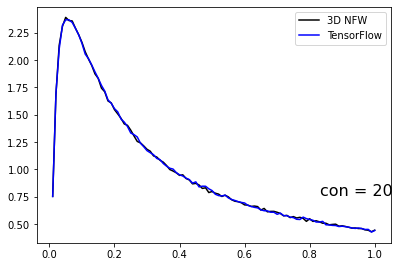

In [12]:
hist = np.histogram(r, bins=100, density=True)
tfhist = np.histogram(RadialNFWProfile(concentration=20, Rvir=1).sample(nsamples), bins=100, density=True)

fig = plt.figure(con)
ax1=fig.add_axes([0.13,0.13,0.82,0.82])
ax1.plot(hist[1][1:], hist[0], color='k', linewidth=1.5,  label='3D NFW')
ax1.plot(tfhist[1][1:], tfhist[0], color='b', linewidth=1.5,  label='TensorFlow')
legend()
ax1.text(0.8, 0.2, str(r'con = %d' % con), transform=ax1.transAxes, fontsize='16')

In [25]:
# Ok, last test, let's try to use HMC to sample from the NFW profile

In [13]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [14]:
concentration = 20
dist = NFWProfile(concentration=concentration, Rvir=1)
distr = RadialNFWProfile(concentration=concentration, Rvir=1)

In [15]:
# Target distribution is proportional to: `exp(-x (1 + x))`.
def unnormalized_log_prob(x):
  # NFW profile plus smooth boundary at Rvir
  x = x / concentration
  r = tf.norm(x, axis=-1)
  return dist.log_prob(x) - tf.clip_by_value(tf.exp(r*3) -tf.exp(3.), 0, 100) #niform(0,1).log_prob(r)

In [16]:
r = np.linspace(0,25,1000)
x = np.array([0,0,1]).reshape([1,3]) * r.reshape([-1,1])

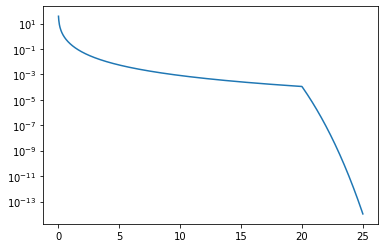

In [17]:
semilogy(r, np.exp(unnormalized_log_prob(x.astype('float32'))))

In [18]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

# Initialize the HMC transition kernel.
num_results = int(1e4)
adaptive_hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_log_prob,
        num_leapfrog_steps=3,
        step_size=0.1)

# Run the chain (with burn-in).
@tf.function
def run_chain():
  # Run the chain (with burn-in).
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      current_state=tf.zeros([100, 3])+0.01*randn(100,3),
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.is_accepted)

  return samples, is_accepted

In [19]:
samples, is_accepted = run_chain()

In [20]:
is_accepted.numpy().sum()/len(is_accepted.numpy().flatten())

0.872719

In [21]:
s = samples[is_accepted] / concentration

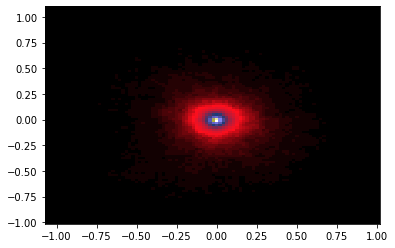

In [22]:
hist2d(s[:,0],s[:,2],100,cmap='gist_stern');

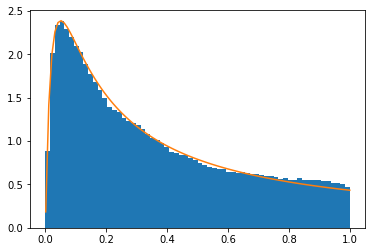

In [26]:
plt.hist(tf.norm(s, axis=-1).numpy(),64, density=True,range=[0,1]);
r = np.linspace(0.001,1,100)
distr = RadialNFWProfile(concentration=concentration, Rvir=1)
plot(r, distr.prob(r));